In [13]:
# QUESTION 1 - IMPLEMENTATION OF LeNeT Model using Non-Linear Activation Function

In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

base_path = os.path.abspath('')
dataset_path = os.path.join(base_path, 'PyCharmProjects/LeNet5_CNN/101_ObjectCategories')
batch_size = 1024
n_epochs = 60
batches = 400
keep_prob = tf.placeholder(tf.float32)


def read_dataset(dataset_path):
    images = []
    labels = []
    label = 0
    ##Python3
    for paths in os.walk(dataset_path).__next__()[1]:
        dir = os.path.join(dataset_path, paths)
        walk = os.walk(dir).__next__()  ##Python3
        for image in walk[2]:
            if image.endswith('.jpg'):
                images.append(os.path.join(dir, image))
                labels.append(label)
        label += 1

    imgs = []
    for img in images:
        imgs.append(cv2.imread(img, cv2.COLOR_BGR2RGB))
    return imgs, labels


imgs, labels = read_dataset(dataset_path)
xx = tf.placeholder(tf.float32, (None, 64, 64, 3))
yy = tf.placeholder(tf.int32, None)
one_hot_Y = tf.one_hot(yy, 101)


def LeNet(x, keep_prob):
    # Conv Layer 1
    weight1 = tf.get_variable("weight0", initializer=tf.truncated_normal(shape=[5, 5, 3, 32], stddev=0.1))
    bias1 = tf.get_variable(name="b_b1", shape=[32],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer1 = tf.nn.conv2d(x, weight1, strides=[1, 1, 1, 1], padding='VALID') + bias1  
    conv_layer1 = tf.nn.relu(conv_layer1)
    pooling1 = tf.nn.max_pool(conv_layer1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

    # Conv layer 2
    weight2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64], stddev=0.1))
    bias2 = tf.get_variable(name="b_b2", shape=[64],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer2 = tf.nn.conv2d(pooling1, weight2, strides=[1, 1, 1, 1], padding='VALID') + bias2
    conv_layer2 = tf.nn.relu(conv_layer2)
    pooling2 = tf.nn.max_pool(conv_layer2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

    # Flatten layer
    flatten_layer = flatten(pooling2)

    # FC layer 1
    fc1_weight1 = tf.get_variable("fc1_weight_1_", initializer=tf.truncated_normal(shape=(256, 1024), stddev=0.1),
                                  regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
    fc1_bias = tf.get_variable(name="fc_01_bias_", shape=[1024],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc1 = tf.matmul(flatten_layer, fc1_weight1) + fc1_bias
    fc1 = tf.nn.relu(fc1)
    # applied DropOut
    # drop_out_1 = tf.nn.dropout(fc1, keep_prob)

    # FC Layer 2
    fc2_weight2 = tf.get_variable("fc_02_weight2_", initializer=tf.truncated_normal(shape=(1024, 84), stddev=0.1),
                                  regularizer=tf.contrib.layers.l2_regularizer(scale=0.01))
    fc2_bias = tf.get_variable(name="fc_02_bias_", shape=[84],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc2 = tf.matmul(fc1, fc2_weight2) + fc2_bias
    fc2 = tf.nn.relu(fc2)

    # apply DropOut to hidden layer
    #  drop_out_2 = tf.nn.dropout(fc2, keep_prob)  # DROP-OUT here

    # FC Layer 3
    fc3_weight3 = tf.Variable(tf.truncated_normal(shape=(84, 101), stddev=0.1))
    fc3_bias = tf.get_variable(name="fc_03_bias_", shape=[101],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    logits = tf.matmul(fc2, fc3_weight3) + fc3_bias

    return logits



###Training
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    logits = LeNet(xx, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_Y)
total_loss = tf.reduce_mean(cross_entropy) + tf.losses.get_regularization_loss()
LR = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)

##Model Evaluation

pred = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_Y, 1))
accu = tf.reduce_mean(tf.cast(pred, tf.float32))
saver = tf.train.Saver()


def visualize_weights(weights):

    plot_weight = np.moveaxis(weights, -1, 0)
    _, axs = plt.subplots(4, 8, figsize=(12, 12))
    axs = axs.flatten()
    for out, ax in zip(plot_weight, axs):
        v_min = plot_weight.min(axis=(0, 1), keepdims=True)
        v_max = plot_weight.max(axis=(0, 1), keepdims=True)
        out = (plot_weight - v_min) / (v_max - v_min)
        ax.imshow(plot_weight)
    plt.show()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batches):
        batch_x, batch_y = X_data[offset:offset + batches], y_data[offset:offset + batches]
        accuracy = sess.run(accu, feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


np_read_img = np.array(imgs)
##Normalize the numpy data
np_read_img = (np_read_img - np_read_img.min()) / (np.ptp(np_read_img))
np_labels = np.asarray(labels)

X_train, X_val, y_train, y_val = train_test_split(np_read_img, np_labels, train_size=0.9, test_size=0.1, random_state=1)
X_train, y_train = shuffle(X_train, y_train)

losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_data = len(X_train)
    print("Training started...")
    for i in range(n_epochs):
        print("EPOCH {} ...".format(i + 1))
        for offset in range(0, total_data, batches):
            end = offset + batches
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss, acc = sess.run([LR, total_loss, accu], feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
            print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

        validation_accuracy = evaluate(X_val, y_val)

        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        saver.save(sess, 'my-Lenet-model')
        print("Model Saved")

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Training started...
EPOCH 1 ...
Iter 0, Loss= 19.249931, Training Accuracy= 0.00000
Iter 0, Loss= 18.001507, Training Accuracy= 0.02000
Iter 0, Loss= 17.741764, Training Accuracy= 0.08500
Iter 0, Loss= 17.417049, Training Accuracy= 0.11750
Iter 0, Loss= 17.164112, Training Accuracy= 0.11750
Iter 0, Loss= 17.051619, Training Accuracy= 0.15000
Iter 0, Loss= 16.799589, Training Accuracy= 0.11000
Iter 0, Loss= 16.629517, Training Accuracy= 0.13750
Iter 0, Loss= 16.520533, Training Accuracy= 0.15000
Iter 0, Loss= 16.316322, Training Accuracy= 0.14750
Iter 0, Loss= 16.216101, Training Accuracy= 0.10750
Iter 0, Loss= 15.965584, Training Accuracy= 0.18250
Iter 0, Loss= 15.769672, Training Accuracy= 0.16750
Iter 0, Loss= 15.511480, Training Accuracy= 0.19500
Iter 0, Loss= 15.353862, Training Accuracy= 0.17000
Iter 0, Loss= 15.252693, Training Accuracy= 0.17000
Ite

In [ ]:
#QUESTION 2.1 - Implementation of LeNet using LINEAR Activation Function

In [3]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

base_path = os.path.abspath('')
dataset_path = os.path.join(base_path, 'PyCharmProjects/LeNet5_CNN/101_ObjectCategories')
batch_size = 1024
n_epochs = 60
batches = 400
keep_prob = tf.placeholder(tf.float32)


def read_dataset(dataset_path):
    images = []
    labels = []
    label = 0
    ##Python3
    for paths in os.walk(dataset_path).__next__()[1]:
        dir = os.path.join(dataset_path, paths)
        walk = os.walk(dir).__next__()  ##Python3
        for image in walk[2]:
            if image.endswith('.jpg'):
                images.append(os.path.join(dir, image))
                labels.append(label)
        label += 1

    imgs = []
    for img in images:
        imgs.append(cv2.imread(img, cv2.COLOR_BGR2RGB))
    return imgs, labels


imgs, labels = read_dataset(dataset_path)
xx = tf.placeholder(tf.float32, (None, 64, 64, 3))
yy = tf.placeholder(tf.int32, None)
one_hot_Y = tf.one_hot(yy, 101)


def LeNet(x, keep_prob):
    # Conv Layer 1
    weight1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 32], stddev=0.1))
    bias1 = tf.get_variable(name="bb1", shape=[32],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer1 = tf.nn.conv2d(x, weight1, strides=[1, 1, 1, 1], padding='VALID') + bias1  ## Hidden Layer 1
    # conv_layer1 = tf.nn.relu(conv_layer1)
    pooling1 = tf.nn.max_pool(conv_layer1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

    # Conv layer 2
    weight2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64], stddev=0.1))
    bias2 = tf.get_variable(name="bb2", shape=[64],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer2 = tf.nn.conv2d(pooling1, weight2, strides=[1, 1, 1, 1], padding='VALID') + bias2
    # conv_layer2 = tf.nn.relu(conv_layer2)
    pooling2 = tf.nn.max_pool(conv_layer2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

    # Flatten layer
    flatten_layer = flatten(pooling2)

    # FC layer 1
    fc1_weight1 = tf.get_variable("fc1_weight_1_", initializer=tf.truncated_normal(shape=(256, 1024), stddev=0.1))
    # regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    fc1_bias = tf.get_variable(name="fc_01_bias_", shape=[1024],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc1 = tf.matmul(flatten_layer, fc1_weight1) + fc1_bias
    # fc1 = tf.nn.relu(fc1)
    # applied DropOut
    # drop_out_1 = tf.nn.dropout(fc1, keep_prob)

    # FC Layer 2
    fc2_weight2 = tf.get_variable("fc_02_weight2_", initializer=tf.truncated_normal(shape=(1024, 84), stddev=0.1))
    # regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    fc2_bias = tf.get_variable(name="fc_02_bias_", shape=[84],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc2 = tf.matmul(fc1, fc2_weight2) + fc2_bias
    # fc2 = tf.nn.relu(fc2)

    # apply DropOut to hidden layer
    #  drop_out_2 = tf.nn.dropout(fc2, keep_prob)  # DROP-OUT here

    # FC Layer 3
    fc3_weight3 = tf.Variable(tf.truncated_normal(shape=(84, 101), stddev=0.1))
    fc3_bias = tf.get_variable(name="fc_03_bias_", shape=[101],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    logits = tf.matmul(fc2, fc3_weight3) + fc3_bias

    return logits



###Training
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    logits = LeNet(xx, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_Y)
total_loss = tf.reduce_mean(cross_entropy) + tf.losses.get_regularization_loss()
LR = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)

##Model Evaluation

pred = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_Y, 1))
accu = tf.reduce_mean(tf.cast(pred, tf.float32))
saver = tf.train.Saver()



def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batches):
        batch_x, batch_y = X_data[offset:offset + batches], y_data[offset:offset + batches]
        accuracy = sess.run(accu, feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


np_read_img = np.array(imgs)
##Normalize the numpy data
np_read_img = (np_read_img - np_read_img.min()) / (np.ptp(np_read_img))
np_labels = np.asarray(labels)

X_train, X_val, y_train, y_val = train_test_split(np_read_img, np_labels, train_size=0.9, test_size=0.1, random_state=1)
X_train, y_train = shuffle(X_train, y_train)

losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_data = len(X_train)
    print("Training started...")
    for i in range(n_epochs):
        print("EPOCH {} ...".format(i + 1))
        for offset in range(0, total_data, batches):
            end = offset + batches
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss, acc = sess.run([LR, total_loss, accu], feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
            print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

        validation_accuracy = evaluate(X_val, y_val)

        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    print("Completed")


Training started...
EPOCH 1 ...
Iter 0, Loss= 24.439350, Training Accuracy= 0.01000
Iter 0, Loss= 21.602234, Training Accuracy= 0.03000
Iter 0, Loss= 21.157534, Training Accuracy= 0.01750
Iter 0, Loss= 20.858334, Training Accuracy= 0.07750
Iter 0, Loss= 19.468836, Training Accuracy= 0.15500
Iter 0, Loss= 19.229336, Training Accuracy= 0.11750
Iter 0, Loss= 18.591507, Training Accuracy= 0.12250
Iter 0, Loss= 18.381207, Training Accuracy= 0.09500
Iter 0, Loss= 18.070042, Training Accuracy= 0.18250
Iter 0, Loss= 17.943810, Training Accuracy= 0.20750
Iter 0, Loss= 17.844995, Training Accuracy= 0.20750
Iter 0, Loss= 17.608646, Training Accuracy= 0.20750
Iter 0, Loss= 17.448303, Training Accuracy= 0.22750
Iter 0, Loss= 17.429358, Training Accuracy= 0.21250
Iter 0, Loss= 17.366337, Training Accuracy= 0.24500
Iter 0, Loss= 17.210726, Training Accuracy= 0.22500
Iter 0, Loss= 17.023918, Training Accuracy= 0.25250
Iter 0, Loss= 16.986736, Training Accuracy= 0.25500
Iter 0, Loss= 16.728477, Trainin

In [ ]:
#  QUESTION2.1 
# What happens if we use a linear activation function in all convolutions and dense layers (except softmax in the last fully connected layer)? 
# Compare training and validation loss (cross-entropy) after and before changing the activation function.

# ANSWER
# I have removed all the relu activation function from all convolutional & Full connected layers of the basic model.
# This is now a straight-forward linear activation model. Using the linear activation function in the neural  
# network might result in loosing the classification capability. 

# From my observation of the results I achieved, using a linear activation function in all the convolution layers 
# provided a minimal decrease in the overall performance (i.e) it me a almost the same or a slightly lower validation 
# accuracy than the non linear activation function. 

# This however would be due to the addition of regularization and other fine tuning hyper parameters used in section 1.
# However in this section, we received a a better Training accuracy with a almost similar or slightly lower validation accuracy
# compared to section 1.

# The validation loss is slightly lower while we are using this linear function because it would be due to overfitting 
# I could achieve around 60% validation accuracy while running the code whereas it is more than 60% in section 1.

# In order to improve the accuracy I have tried to increase the number of layers in my next section to see the
# performance of the model.

In [ ]:
##### QUESTION 2.2 - IMPLEMENTATION OF ADDING ADDITIONAL LAYERS TO THE MODEL

In [20]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

base_path = os.path.abspath('')
dataset_path = os.path.join(base_path, 'PyCharmProjects/LeNet5_CNN/101_ObjectCategories')
batch_size = 1024
n_epochs = 60
batches = 400
keep_prob = tf.placeholder(tf.float32)


def read_dataset(dataset_path):
    images = []
    labels = []
    label = 0
    ##Python3
    for paths in os.walk(dataset_path).__next__()[1]:
        dir = os.path.join(dataset_path, paths)
        walk = os.walk(dir).__next__()  ##Python3
        for image in walk[2]:
            if image.endswith('.jpg'):
                images.append(os.path.join(dir, image))
                labels.append(label)
        label += 1

    imgs = []
    for img in images:
        imgs.append(cv2.imread(img, cv2.COLOR_BGR2RGB))
    return imgs, labels


imgs, labels = read_dataset(dataset_path)
xx = tf.placeholder(tf.float32, (None, 64, 64, 3))
yy = tf.placeholder(tf.int32, None)
one_hot_Y = tf.one_hot(yy, 101)


def LeNet(x, keep_prob):
    # Conv Layer 1
    weight1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 32], stddev=0.1))
    bias1 = tf.get_variable(name="bias_1_", shape=[32],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer1 = tf.nn.conv2d(x, weight1, strides=[1, 1, 1, 1], padding='VALID') + bias1  ## Hidden Layer 1
    # conv_layer1 = tf.nn.relu(conv_layer1)
    pooling1 = tf.nn.max_pool(conv_layer1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

    # Conv layer 2
    weight2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 48], stddev=0.1))
    bias2 = tf.get_variable(name="bias_2", shape=[48],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer2 = tf.nn.conv2d(pooling1, weight2, strides=[1, 1, 1, 1], padding='VALID') + bias2
    # conv_layer2 = tf.nn.relu(conv_layer2)
    pooling2 = tf.nn.max_pool(conv_layer2, ksize=[1, 1, 1, 1], strides=[1, 1, 1, 1], padding='VALID')

    # Conv layer 3
    weight3 = tf.Variable(tf.truncated_normal(shape=[5, 5, 48, 64], stddev=0.1))
    bias3 = tf.get_variable(name="bias_3", shape=[64],
                            initializer=tf.random_normal_initializer(stddev=0.1))
    conv_layer3 = tf.nn.conv2d(pooling2, weight3, strides=[1, 1, 1, 1], padding='VALID') + bias3
    # conv_layer3 = tf.nn.relu(conv_layer3)
    pooling3 = tf.nn.max_pool(conv_layer3, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='VALID')

    # Flatten layer
    flatten_layer = flatten(pooling3)

    # FC layer 1
    fc1_weight1 = tf.get_variable("fc1_weight_1", initializer=tf.truncated_normal(shape=(256, 1024), stddev=0.1))
    # regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    fc1_bias = tf.get_variable(name="fc1_bias_01", shape=[1024],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc1 = tf.matmul(flatten_layer, fc1_weight1) + fc1_bias
    # fc1 = tf.nn.relu(fc1)
    # applied DropOut
    # drop_out_1 = tf.nn.dropout(fc1, keep_prob)

    # FC Layer 2
    fc2_weight2 = tf.get_variable("fc2_weight_2", initializer=tf.truncated_normal(shape=(1024, 84), stddev=0.1))
    # regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    fc2_bias = tf.get_variable(name="fc2_bias_02", shape=[84],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    fc2 = tf.matmul(fc1, fc2_weight2) + fc2_bias
    # fc2 = tf.nn.relu(fc2)

    # apply DropOut to hidden layer
    #  drop_out_2 = tf.nn.dropout(fc2, keep_prob)  # DROP-OUT here

    # FC Layer 3
    fc3_weight3 = tf.Variable(tf.truncated_normal(shape=(84, 101), stddev=0.1))
    fc3_bias = tf.get_variable(name="fc3_bias_03", shape=[101],
                               initializer=tf.random_normal_initializer(stddev=0.1))
    logits = tf.matmul(fc2, fc3_weight3) + fc3_bias

    return logits



###Training
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    logits = LeNet(xx, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_Y)
total_loss = tf.reduce_mean(cross_entropy) + tf.losses.get_regularization_loss()
LR = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)

##Model Evaluation

pred = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_Y, 1))
accu = tf.reduce_mean(tf.cast(pred, tf.float32))
saver = tf.train.Saver()



def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batches):
        batch_x, batch_y = X_data[offset:offset + batches], y_data[offset:offset + batches]
        accuracy = sess.run(accu, feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


np_read_img = np.array(imgs)
##Normalize the numpy data
np_read_img = (np_read_img - np_read_img.min()) / (np.ptp(np_read_img))
np_labels = np.asarray(labels)

X_train, X_val, y_train, y_val = train_test_split(np_read_img, np_labels, train_size=0.9, test_size=0.1, random_state=1)
X_train, y_train = shuffle(X_train, y_train)

losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_data = len(X_train)
    print("Training started...")
    for i in range(n_epochs):
        print("EPOCH {} ...".format(i + 1))
        for offset in range(0, total_data, batches):
            end = offset + batches
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss, acc = sess.run([LR, total_loss, accu], feed_dict={xx: batch_x, yy: batch_y, keep_prob: 0.8})
            print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

        validation_accuracy = evaluate(X_val, y_val)

        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    print("Completed")


Training started...
EPOCH 1 ...
Iter 0, Loss= 162.346588, Training Accuracy= 0.01250
Iter 0, Loss= 153.672913, Training Accuracy= 0.03500
Iter 0, Loss= 146.498627, Training Accuracy= 0.08750
Iter 0, Loss= 144.498749, Training Accuracy= 0.01000
Iter 0, Loss= 138.156784, Training Accuracy= 0.02750
Iter 0, Loss= 134.824295, Training Accuracy= 0.01750
Iter 0, Loss= 130.534760, Training Accuracy= 0.03750
Iter 0, Loss= 125.835457, Training Accuracy= 0.13250
Iter 0, Loss= 124.369774, Training Accuracy= 0.18250
Iter 0, Loss= 122.654457, Training Accuracy= 0.18250
Iter 0, Loss= 118.579399, Training Accuracy= 0.22000
Iter 0, Loss= 116.115669, Training Accuracy= 0.16250
Iter 0, Loss= 113.245789, Training Accuracy= 0.13250
Iter 0, Loss= 110.857445, Training Accuracy= 0.08500
Iter 0, Loss= 108.302475, Training Accuracy= 0.14250
Iter 0, Loss= 106.126648, Training Accuracy= 0.14750
Iter 0, Loss= 103.805092, Training Accuracy= 0.19000
Iter 0, Loss= 101.903084, Training Accuracy= 0.23750
Iter 0, Loss= 

In [ ]:
#Question 2.2: Can we compensate for the effect of removing the non-linear activation function by adding more convolution 
#linear layers? 

# Answer: In this section the number of hidden convolutional layers are increased.
# This increases the depth of the model and gives enough strength to the model capacity.
# From the observation of the results, the validation loss is much lesser than the previous section. 
# However the Validation accuracy seems to be lesser now compared to the previous & a much better training accuracy
# than the previous.

# Thus adding the number of layers proved to improved at the initial stage and achieve almost the same accuracy 
# as the above. So we cannot assure that adding the new layer would compensate the effect of removing the non-linear
# activation function.

# So in my case, adding the layers instead of removing the non-linear activation function is useful unless
# we avoid overfitting and resolve other issues.

# In order to get a much better performance in accuracy, we can try resolving the overfitting issues and try dropout (may be)
# and also try to fine tune the hyper parameters to achieve better improvement in performance.

In [ ]:
##Assignment_2_q_3. Visualizing the weights

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my-Lenet-model
visualized


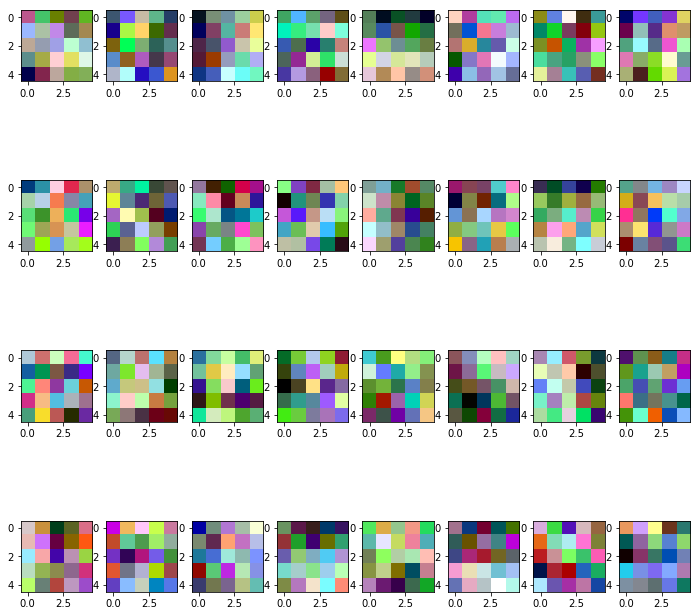

Completed


In [4]:
def visualize_weights(weights):
    plot_weight = np.moveaxis(weights, -1, 0)
    _, axs = plt.subplots(4, 8, figsize=(12, 12))
    axs = axs.flatten()
    for out, ax in zip(plot_weight, axs):
        v_min = out.min(axis=(0, 1), keepdims=True)
        v_max = out.max(axis=(0, 1), keepdims=True)
        out = (out - v_min) / (v_max - v_min)
        ax.imshow(out)
    print("visualized")
    plt.show()

sess = tf.Session()
new_saver = tf.train.import_meta_graph('my-Lenet-model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
var_name = 'weight0'
graph = tf.get_default_graph()
w2 = graph.get_tensor_by_name(var_name + ':0')
w2_saved = sess.run(w2)  # print out tensor
visualize_weights(w2_saved)
print("Completed")